In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from torch.utils.data import DataLoader, TensorDataset
from sindy_utils import sindy_library
import itertools
from sindy_utils import library_size
from functions import Rossler, Solution, jacobian, plot
from ae import Autoencoder

In [13]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =[0.1,1,0.1]
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 17

In [14]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)
v3 = np.array(xs[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

In [15]:
v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
input_dim = 3
latent_dim = 3
poly_order = 2
autoencoder = Autoencoder(tau, RosslerSystem=True, l = {'l1': 1e-1, 'l2': 1e-1, 'l3': 0, 'l4': 0, 'l5': 0, 'l6': 0, 'l1_rossler': 1e-2, 'l2_rossler':1e-2})
learning_rate = 1e-3
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [16]:
torch.manual_seed(123)

In [17]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    Loss = autoencoder.loss(v, dvdt, criterion)
    Loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Loss.item():.4f}')

Epoch [100/1000], Loss: 0.6388
Epoch [200/1000], Loss: 0.2705
Epoch [300/1000], Loss: 0.2204
Epoch [400/1000], Loss: 0.1843
Epoch [500/1000], Loss: 0.1673
Epoch [600/1000], Loss: 0.1552
Epoch [700/1000], Loss: 0.1505
Epoch [800/1000], Loss: 0.1593
Epoch [900/1000], Loss: 0.1746
Epoch [1000/1000], Loss: 0.1927


In [18]:
autoencoder.eval() 
print(autoencoder.a.item(), autoencoder.b.item(), autoencoder.c.item())
latent_variables = autoencoder.encode(v) 

0.1368861049413681 0.21188011765480042 9.911881446838379


In [19]:
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

# plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)

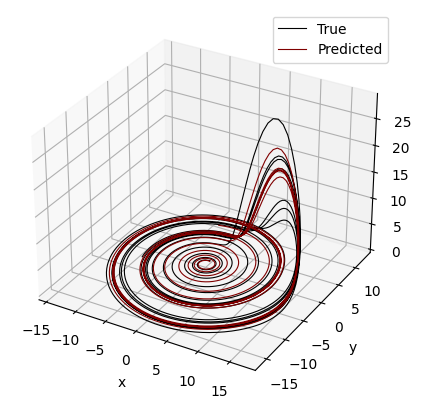

In [20]:
a = autoencoder.a.item()
b = autoencoder.b.item()
c = autoencoder.c.item()

x,y,z = Solution(Rossler, [x_ae[0], y_ae[0], z_ae[0]], t[:len(x_ae)], [a,b,c])

fig = plt.figure(figsize=(9, 5))
ax3d = fig.add_subplot(1, 1, 1, projection='3d')

ax3d.plot(xs, ys, zs, lw=.8,label='True', color= 'k')
ax3d.plot(x, y, z, lw=.8,label='Predicted', color= 'maroon')
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel("z")
ax3d.legend()
plt.show()